In [1]:
import sys
# sys.path.append('../')
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import numpy as np
import matplotlib.pyplot as plt
plt.rc('text',usetex=True)
plt.rc('font',family='serif')

from pylab import *
import pickle
from math import log
from torch.nn import parameter

import torch 
import torch.nn as nn

if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

from fracturbulence.common import *
from fracturbulence.Calibration import CalibrationProblem
from fracturbulence.DataGenerator import OnePointSpectraDataGenerator

from time import time

from pathlib import Path

savedir = Path().resolve() / "data" / "results" 

# Synthetic Data Fit

This notebook showcases the simplest functionality of DRDMannTurb: using a small neural network which fits synthetic data. This experiment is the same as discussed in the first DRD paper. 

In [2]:
import fracturbulence as ft

In [3]:

CONSTANTS_CONFIG = {
    "type_EddyLifetime": "customMLP",  # CALIBRATION : 'tauNet',  ### 'const', TwoThird', 'Mann', 'customMLP', 'tauNet'
    "type_PowerSpectra": "RDT",  ### 'RDT', 'zetaNet', 'C3Net', 'Corrector'
    "learn_nu": False,  ### NOTE: Experiment 1: False, Experiment 2: True
    "plt_tau": True,
    "hlayers": [10, 10],  # ONLY NEEDED FOR CUSTOMNET OR RESNET
    "tol": 1.0e-9,  ### not important
    "lr": 1,  ### learning rate
    "penalty": 1,  # CALIBRATION: 1.e-1,
    "regularization": 1.0e-5,  # CALIBRATION: 1.e-1,
    "nepochs": 10,
    "curves": [0, 1, 2, 3],
    "data_type": "Kaimal",  # CALIBRATION: 'Custom', ### 'Kaimal', 'SimiuScanlan', 'SimiuYeo', 'iso'
    "spectra_file": "Spectra.dat",
    "Uref": 10,  # m/s
    "zref": 1,  # m
    "domain": torch.logspace(
        -1, 2, 20
    ),  # np.logspace(-4, 2, 40), ### NOTE: Experiment 1: np.logspace(-1, 2, 20), Experiment 2: np.logspace(-2, 2, 40)
    "noisy_data": 0.0,  # 0*3.e-1, ### level of the data noise  ### NOTE: Experiment 1: zero, Experiment 2: non-zero
    "output_folder": str(savedir),
    "input_folder": "/Users/gdeskos/work_in_progress/WindGenerator/script/",
}


zref = CONSTANTS_CONFIG["zref"]
# Hub height in meters
Uref = CONSTANTS_CONFIG["Uref"]
# Average Hub height velocity in m/s
Iref = 0.14
sigma1 = Iref * (0.75 * Uref + 5.6)
Lambda1 = 42
# Longitudinal turbulence scale parameter at hub height

z0 = 0.01
ustar = 0.41 * Uref / log(zref / z0)

# NOTE: values taken from experiment1 in the paper
L = 0.59
Gamma = 3.9
sigma = 3.2

['relu', 'relu']
DataValues is on 0


/home/ai/miniconda3/envs/fracturbulence/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]



Calibrating MannNet...
torch.Size([80])
Initial loss:  0.08958571220307977


/home/ai/miniconda3/envs/fracturbulence/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)




{Calibration.py -- calibrate} Calibration terminated.

loss = 0.0056803800991622995
tol  = 1e-09
k1.size: torch.Size([20])   self.kF_data_vals: torch.Size([80])


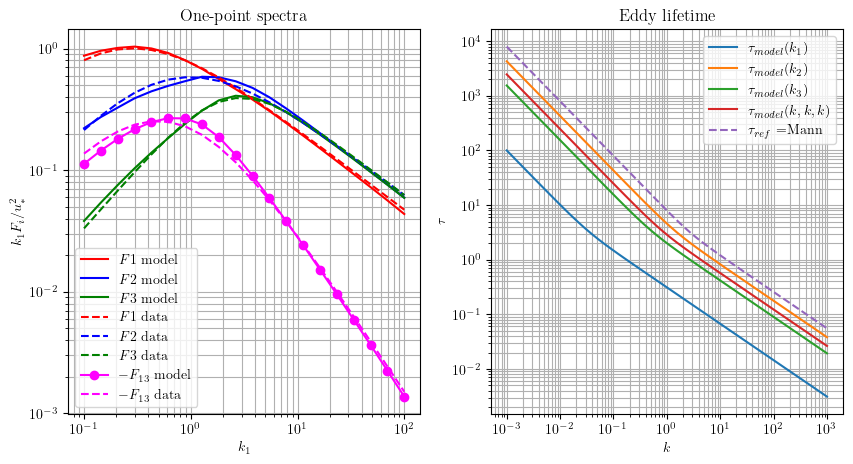

In [4]:
start = time() 

pb = CalibrationProblem(**CONSTANTS_CONFIG)
parameters = pb.parameters
parameters[:3] = [log(L), log(Gamma), log(sigma)] #All of these parameters are positive 
    #so we can train the NN for the log of these parameters. 
pb.parameters = parameters[:len(pb.parameters)]
k1_data_pts = CONSTANTS_CONFIG['domain'] #np.logspace(-1, 2, 20)
DataPoints  = [ (k1, 1) for k1 in k1_data_pts ]
Data = OnePointSpectraDataGenerator(DataPoints=DataPoints, **CONSTANTS_CONFIG).Data

DataValues = Data[1]

IECtau=MannEddyLifetime(k1_data_pts*L)
kF = pb.eval(k1_data_pts)

opt_params = pb.calibrate(Data=Data, **CONSTANTS_CONFIG); 

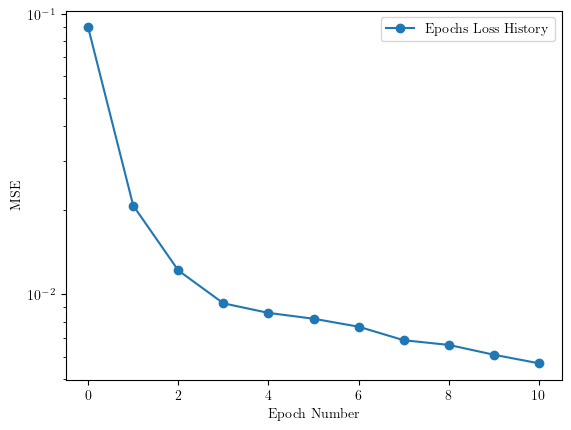

In [5]:
plt.figure()

plt.plot( pb.loss_history_epochs, 'o-', label="Epochs Loss History")
plt.legend() 
plt.xlabel("Epoch Number")
plt.ylabel("MSE")
plt.yscale('log')

plt.show() 